## Race Prediction Machine Learning Model
C964 Computer Science Capstone  
Western Governors University  
Russell Taylor  
December 6, 2020

### Import Tools
#### Import Pandas, NumPy, and Matplotlib

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Import Scikit-learn

In [58]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

#### Set Random Seed

In [59]:
np.random.seed(45)

### Import Data

In [60]:
import glob
import os
path = r'race_results'
all_files = glob.glob(os.path.join(path, "*.csv"))

race_results = pd.concat((pd.read_csv(f) for f in all_files), ignore_index = True)
race_results.head()
# pd.set_option('display.max_rows', None)

,Race,Year,Cutoff,Place,First,Last,City,Location,Age,Gender,GP,Time,Rank
0,Javelina,2020,30,1,Tim,Tollefson,Mammoth Lakes,CA,35,M,1,13:28:04,96.84
1,Javelina,2020,30,2,Nick,Coury,Scottsdale,AZ,33,M,2,14:09:48,84.03
2,Javelina,2020,30,3,Nicole,Bitter,Phoenix,AZ,38,F,1,15:17:47,94.22
3,Javelina,2020,30,4,Darce,Claus,Bonners Ferry,ID,49,F,2,15:58:45,95.29
4,Javelina,2020,30,5,Sean,Van Horn,Carbondale,CO,34,M,3,16:01:10,90.22


In [61]:
race_results["Time"]

0        13:28:04
1        14:09:48
2        15:17:47
3        15:58:45
4        16:01:10
           ...   
12269    32:28:39
12270    32:33:20
12271    32:36:58
12272    32:42:04
12273    32:43:12
Name: Time, Length: 12274, dtype: object

### Clean Data
#### Convert Finish Times to Integers

In [62]:
race_results["Time"] = pd.to_timedelta(race_results["Time"]).dt.total_seconds()

#### Remove DNFs and DNSs

In [63]:
race_results = race_results[race_results["Place"] > 0]
len(race_results)

11679

#### Remove Erroneous Finish Times 

In [64]:
race_results = race_results[race_results["Time"] > 43200]
outlier = race_results[race_results["Race"] == "Cascade Crest"]
race_results.drop(outlier[outlier["Time"] > 144000].index, inplace = True)
len(race_results)

11667

#### Fill Null Fields

In [65]:
race_results.fillna("INTL", inplace = True)

### Display data
#### Finish Times by Race

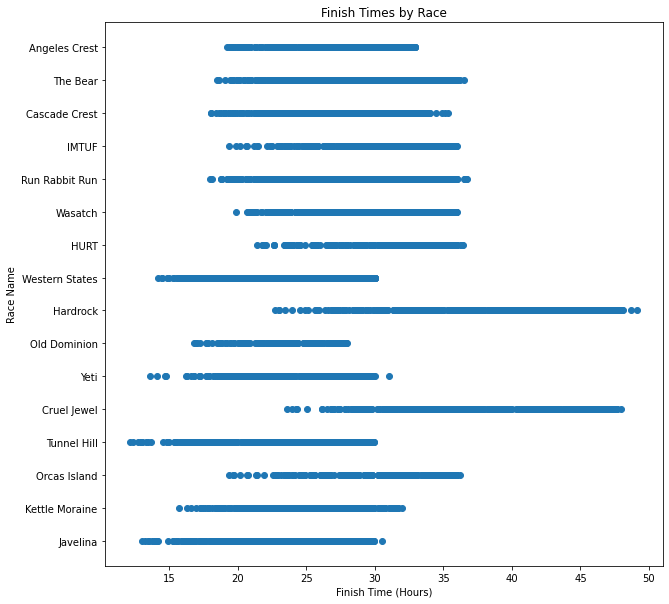

In [66]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(race_results["Time"] / 3600, race_results["Race"])
ax.set(title = "Finish Times by Race",
       xlabel = "Finish Time (Hours)",
       ylabel = "Race Name")
fig.savefig("images/sample-plot.png")
plt.show()

In [67]:
race_results["Race"] = pd.Categorical(race_results["Race"])
race_results["RaceID"] = race_results["Race"].cat.codes
race_results

,Race,Year,Cutoff,Place,First,Last,City,Location,Age,Gender,GP,Time,Rank,RaceID
0,Javelina,2020,30,1,Tim,Tollefson,Mammoth Lakes,CA,35,M,1,48484.0,96.84,6
1,Javelina,2020,30,2,Nick,Coury,Scottsdale,AZ,33,M,2,50988.0,84.03,6
2,Javelina,2020,30,3,Nicole,Bitter,Phoenix,AZ,38,F,1,55067.0,94.22,6
3,Javelina,2020,30,4,Darce,Claus,Bonners Ferry,ID,49,F,2,57525.0,95.29,6
4,Javelina,2020,30,5,Sean,Van Horn,Carbondale,CO,34,M,3,57670.0,90.22,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12269,Angeles Crest,2015,33,94,Peter,Hulbert,Edina,MN,36,M,74,116919.0,59.48,0
12270,Angeles Crest,2015,33,95,Tim,Steele,San Ramon,CA,53,M,75,117200.0,66.83,0
12271,Angeles Crest,2015,33,96,John,Kawaharada,Los Angeles,CA,47,M,76,117418.0,66.26,0
12272,Angeles Crest,2015,33,97,Ryan,Launder,Landers,CA,39,M,77,117724.0,68.24,0


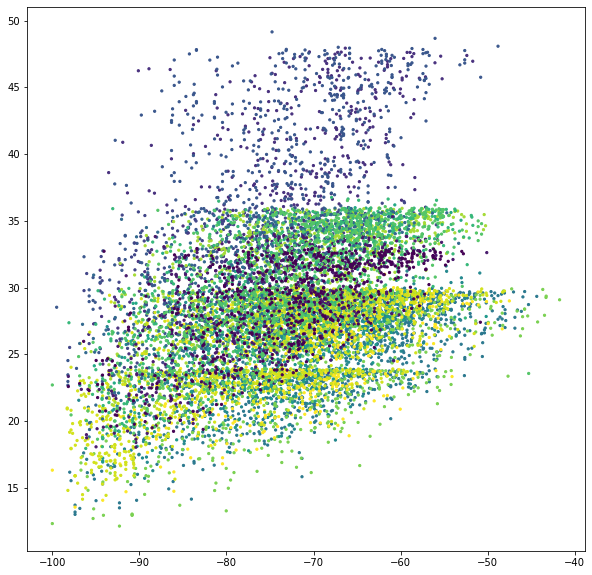

In [68]:
# display = race_results[race_results["RaceID"] == 8]
display = race_results
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(x = -display["Rank"], 
           y = display["Time"] / 3600,
           c = display["RaceID"],
           s = 5)
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

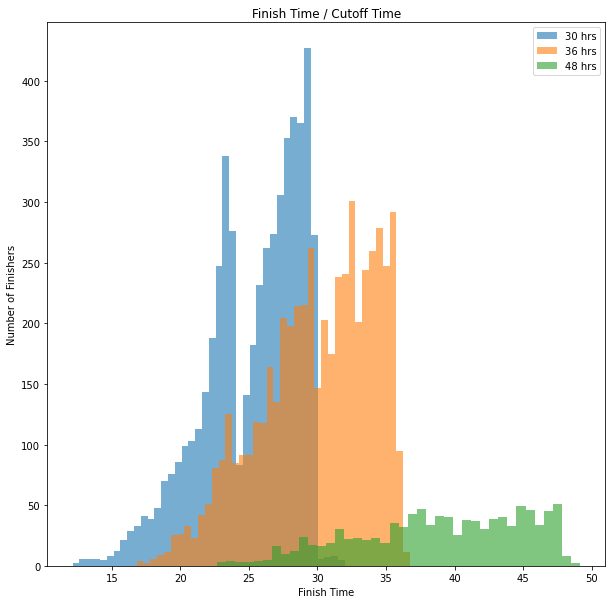

In [69]:
# display = race_results[race_results["RaceID"] == 8]

display = race_results
fig, ax = plt.subplots(figsize = (10, 10))

# display = race_results

a = display[display["Cutoff"] == 30]
b = display[display["Cutoff"] == 48]
c = display.drop(a.index).drop(b.index)

ax.hist(a["Time"] / 3600, alpha = 0.6, bins = 40)
ax.hist(c["Time"] / 3600, alpha = 0.6, bins = 40)
ax.hist(b["Time"] / 3600, alpha = 0.6, bins = 40)

plt.legend(["30 hrs", "36 hrs", "48 hrs"])
plt.ylabel("Number of Finishers")
plt.xlabel("Finish Time")
plt.title("Finish Time / Cutoff Time") 
plt.show()

### Descriptive Data Method: Randomized PCM
#### Heading

### Non-Descriptive Data Method: Random Forest Regression
#### Remove Extraneous Columns

In [70]:
race_results.drop(["Race", "Year", "First", "Last", "City", "Location", "Place", "GP"], 
                  axis = 1, 
                  inplace = True)

#### Split the Data into Features and Labels

In [71]:
race_results_shuffled = race_results.sample(frac = 1)
x = race_results_shuffled.drop("Time", axis = 1)
y = race_results_shuffled["Time"]

#### Convert Categorical Features into Numerical Form

In [72]:
categorical_features = ["Gender"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], 
                                remainder = "passthrough")
x = transformer.fit_transform(x)

#### Split the Data into Training and Test Sets

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

#### Run the Random Forest Regression Algorithm

In [74]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

### Evaluate the Results
#### Training Set Evalualtion: R²

In [54]:
model.score(x_train, y_train)

0.9691883389563325

#### Test Set Evalualtion: R²

In [55]:
model.score(x_test, y_test)

0.7805859053727743

#### Calculate the Mean Absolute Error

In [ ]:
y_preds = model.predict(x_test)
mae = mean_absolute_error(y_test, y_preds)

pd.to_timedelta(mae, unit = "s")

In [ ]:
df = pd.DataFrame()
df["Predicted"] = pd.to_timedelta(y_preds.round(0), unit = "s")
df["Actual"] = pd.to_timedelta(np.array(y_test), unit = "s")
df["Difference"] = abs(df["Predicted"] - df["Actual"])
# max_df = df[df["Difference"] > '1 days']
df

In [ ]:
display = df
fig, ax = plt.subplots(figsize = (10, 10))

# a = display[display["Cutoff"] == 30]
# b = display[display["Cutoff"] == 48]
# c = display.drop(a.index).drop(b.index)


ax.hist(y_preds, alpha = 0.6, bins = 40)
ax.hist(y_test, alpha = 0.6, bins = 40)

plt.legend(["30 hrs", "36 hrs", "48 hrs"])
plt.ylabel("Number of Finishers")
plt.xlabel("Finish Time")
plt.title("Finish Time / Cutoff Time") 
plt.show()

In [ ]:
display = df
display["index"] = display.index
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(x = display["Actual"], 
           y = display["Predicted"],
           c = display["Difference"],
           s = 5)
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

In [ ]:
display = df
display["index"] = display.index
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(x = display["Predicted"], 
           y = display["Difference"],
           c = display["Actual"],
           s = 5)
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

In [ ]:
display = df
display.sort_values("Predicted", inplace=True)
display.reset_index(drop = True, inplace = True)
display

In [ ]:
display["index"] = display.index
fig, ax = plt.subplots(figsize = (10, 10))
# ax.bar(y_preds.index, y_preds)
ax.bar(display["index"], display["Predicted"])
ax.bar(display["index"], display["Actual"])
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

In [ ]:
display = df
display.sort_values(by = ["Actual"], inplace = True)
display.reset_index(drop = True, inplace = True)
display["index"] = display.index
fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(display["index"], display["Actual"])
ax.bar(display["index"], display["Predicted"])
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

In [ ]:
display = df
display.sort_values("Actual", inplace=True)
display.reset_index(drop = True, inplace = True)
display["index"] = display.index
fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(display["index"], display["Actual"])
ax.bar(display["index"], display["Difference"])
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

In [ ]:
display = df
display.sort_values("Predicted", inplace=True)
display.reset_index(drop = True, inplace = True)
display["index"] = display.index
fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(display["index"], display["Predicted"])
ax.bar(display["index"], display["Difference"])
# race_results.set(title = "Finish Times by Race",
#        xlabel = "Finish Time (Hours)",
#        ylabel = "Race Name")
plt.show()

### PCA

In [ ]:
race_results_shuffled = race_results.sample(frac = 1)
x = race_results_shuffled.drop("Time", axis = 1)
y = race_results_shuffled["Time"]

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)